# Shadow Tomography
The following code was developed in accordance to the structure outline in the paper [Predicting Many Properties of a Quantum System from Very Few Measurements](https://arxiv.org/abs/2002.08953). In addition the [PennyLane demo](https://pennylane.ai/qml/demos/tutorial_classical_shadows/#huang2020) on classical shadows help inform some of the choices of structure and scripts based on their examples are clear marked as such.

Necessary Libraries:

In [89]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import *
from qiskit.primitives import StatevectorSampler

Generating the classical shadow. The following scripts are based on qiskit circuits.

In [90]:
def generate_classical_shadow(circuit, shadow_size, num_qubits):

    # Generate the measurment scheme. This is the random Pauli measurements that will be done on the qubits after each shot of the circuit.
    measurement_scheme = np.random.randint(0, 3, (shadow_size, num_qubits), dtype=int)

    # Create a matrix to store the results of the measurements.
    measurements = np.zeros((shadow_size, num_qubits))

    # Create a sampler to simulate the quantum circuit on a single shot.
    sampler = StatevectorSampler(default_shots=1)

    # 
    for i in range(shadow_size):

        # Apply the measurement scheme to the qubits
        qc = circuit.copy()

        for j in range(num_qubits):
            if measurement_scheme[i][j] == 0:
                qc.h(j)
            elif measurement_scheme[i][j] == 1:
                qc.h(j)
                qc.sdg(j)

        qc.measure_all()

        # Run the sampler on the quantum circuit and store the result.
        result = sampler.run([qc]).result()[0]

        # Store the bitstrings representing the measured basis states. Because the sampler is configered to run the circuit once, there is only one result.
        counts = result.data.meas.get_counts()   

        # Get the single bitstring.
        states = list(list(counts.keys())[0])
        # The bit string is ordered with qubit n on the left and qubit 0 on the right. We want to reverse this order.
        states.reverse()

        # Store the results of the measurements.
        for j in range(num_qubits):
            measurements[i][j] = 0 if states[j] == '0' else 1

    return measurements, measurement_scheme

In [91]:
def reconstruct_state(shadow):

    # Unpack the shadow.
    measurements, measurement_scheme = shadow

    # Get the shadow size.
    shadow_size = measurements.shape[0]
    # Get the number of qubits.
    num_qubits = measurements.shape[1]

    # Computational basis states.
    zero_state = np.matrix([[1,0],[0,0]], dtype=complex)
    one_state = np.matrix([[0,0],[0,1]], dtype=complex)

    # Local qubit unitaries. 
    phase_z = np.matrix([[1,0],[0,-1j]], dtype=complex)
    hadamard = np.matrix([[1,1],[1,-1]], dtype=complex)/np.sqrt(2)
    identity = np.matrix([[1,0],[0,1]], dtype=complex)

    # Rotations to measure each of the paulis.
    X = hadamard
    Y = hadamard @ phase_z
    Z = identity

    # Tomographically complete set of unitaries. (The pauli basis is tomographically complete.) 
    unitary_ensemble = [X, Y, Z]

    # Array to store the estimated density matrix.
    rho_estimated = np.zeros((2**num_qubits, 2**num_qubits), dtype=complex)

    for i in range(shadow_size):

        # Array to store the density matrix at each snapshot.
        rho_snapshot = [1]

        for j in range(num_qubits):

            # Implementation of formula S44 from the preskill paper.
            U = unitary_ensemble[measurement_scheme[i][j]]
            if measurements[i][j] == 0:
                b_state = zero_state
            else:
                b_state = one_state

            rho_local = 3 * (U.H @ b_state @ U) - identity

            rho_snapshot = np.kron(rho_snapshot, rho_local)

        # Average all the inverted basis states to get an approximation of the density matrix.

        rho_estimated += rho_snapshot

    return rho_estimated/shadow_size

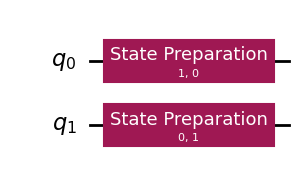

In [92]:
num_qubits = 2
trivial_2_qubit_state = [0, 0, 1, 0]

# Instantiate a quantum register with two qubits.
trivial_2_qubit_qr = QuantumRegister(num_qubits, 'q')

# Create a quantum circuit and add the prepare_state function acting on qubits 0 and 1.
trivial_2_qubit_qc = QuantumCircuit(trivial_2_qubit_qr)
trivial_2_qubit_qc.prepare_state(state = [1,0], qubits=0)
trivial_2_qubit_qc.prepare_state(state = [0,1], qubits=1)

# Draw the circuit in mpl (matplotlib).
trivial_2_qubit_qc.draw('mpl')

#Note: Qiskit is little endian so a 3 qubit tensor product is ordered as |q2> |q1> |q0>. Therefore preparing qubit 0 in state 0 and qubit 1 in state 1 give the tensor product state |10> = |1> |0>.


In [93]:
shadow = generate_classical_shadow(trivial_2_qubit_qc, 1000, 2)

rho_estimated = reconstruct_state(shadow)
print(np.round(rho_estimated, decimals = 2))

phi = np.matrix(trivial_2_qubit_state).T

rho_expected = phi @ phi.H
print(rho_expected)

#print(operator_distance(rho_estimated, rho_expected))

# (25/06/2024) Note the swapped entries. Between the rho_estimated and rho_expected. The 0.97 in the rho_estimaed should be where the 1 is in the rho_expected. Fixed this by changing the order of the tensor product in the end of the reconstruct_from_shadow function (Changed this back as I think it causes other issues. It is not the root of the problem.).

# (26/06/2024) Large off-diagonal entries. Where are these coming from??? FIXED

[[ 0.07+0.j    0.01+0.01j  0.01+0.01j -0.06+0.01j]
 [ 0.01-0.01j  0.94+0.j   -0.  -0.05j -0.03-0.j  ]
 [ 0.01-0.01j -0.  +0.05j -0.02+0.j   -0.  +0.j  ]
 [-0.06-0.01j -0.03+0.j   -0.  -0.j    0.01+0.j  ]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 0 0 0]]


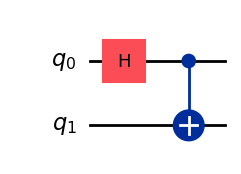

In [94]:
num_qubits = 2
bell_state = [1/np.sqrt(2), 0, 0, 1/np.sqrt(2)]

# Instantiate a quantum register with two qubits.
bell_state_qr = QuantumRegister (num_qubits, 'q')

# Create a quantum circuit with a hadamard gate acting on qubit 0
# and a CNOT gate with control qubit 0 and target qubit 1. This will prepare a bell state.
bell_state_qc = QuantumCircuit(bell_state_qr)
bell_state_qc.h(0)
bell_state_qc.cx(0, 1)

# Draw the ciruit in mpl (matplotlib).
bell_state_qc.draw("mpl")

In [95]:
shadow = generate_classical_shadow(bell_state_qc, 1000, 2)

rho_estimated = reconstruct_state(shadow)
print(np.round(rho_estimated, decimals = 2))

phi = np.matrix(bell_state).T

rho_expected = phi @ phi.H
print(rho_expected)

#print(operator_distance(rho_estimated, rho_expected))

# (28/06/2024) I think it is closer... The 0.5 on the anti-diagonal are there but in the wrong spot. Not sure exactly what is going on here.

[[ 0.45+0.j    0.01-0.j   -0.02-0.j    0.03-0.53j]
 [ 0.01+0.j    0.04+0.j    0.47+0.02j  0.04+0.01j]
 [-0.02+0.j    0.47-0.02j  0.04+0.j    0.04+0.02j]
 [ 0.03+0.53j  0.04-0.01j  0.04-0.02j  0.47+0.j  ]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
